In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib agg

import matplotlib.pyplot as plt
import numpy as np
import visualization
from data import datasets, evaluation
import transformation
import jax
import jax.numpy as jnp
from jax import tree_util
from transformation import MLP
import flax.linen as nn
from flax.core import freeze
import optax
from inference import point_estimate
from utils import MLPSymmetryHelper

#latent_dim_gt = 4
output_dim = 10
embedding_dim = output_dim

In [2]:
from typing import Any, Callable, Sequence
from flax.linen.module import Module


class Sequential(Module):
    layers: Sequence[Callable[..., Any]]

    def __call__(self, *args, **kwargs):
        if not self.layers:
            raise ValueError(f'Empty Sequential module {self.name}.')

        outputs = self.layers[0](*args, **kwargs)
        for layer in self.layers[1:]:
            outputs = layer(outputs)
        return outputs

(13107, 10) (3277, 10)


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]


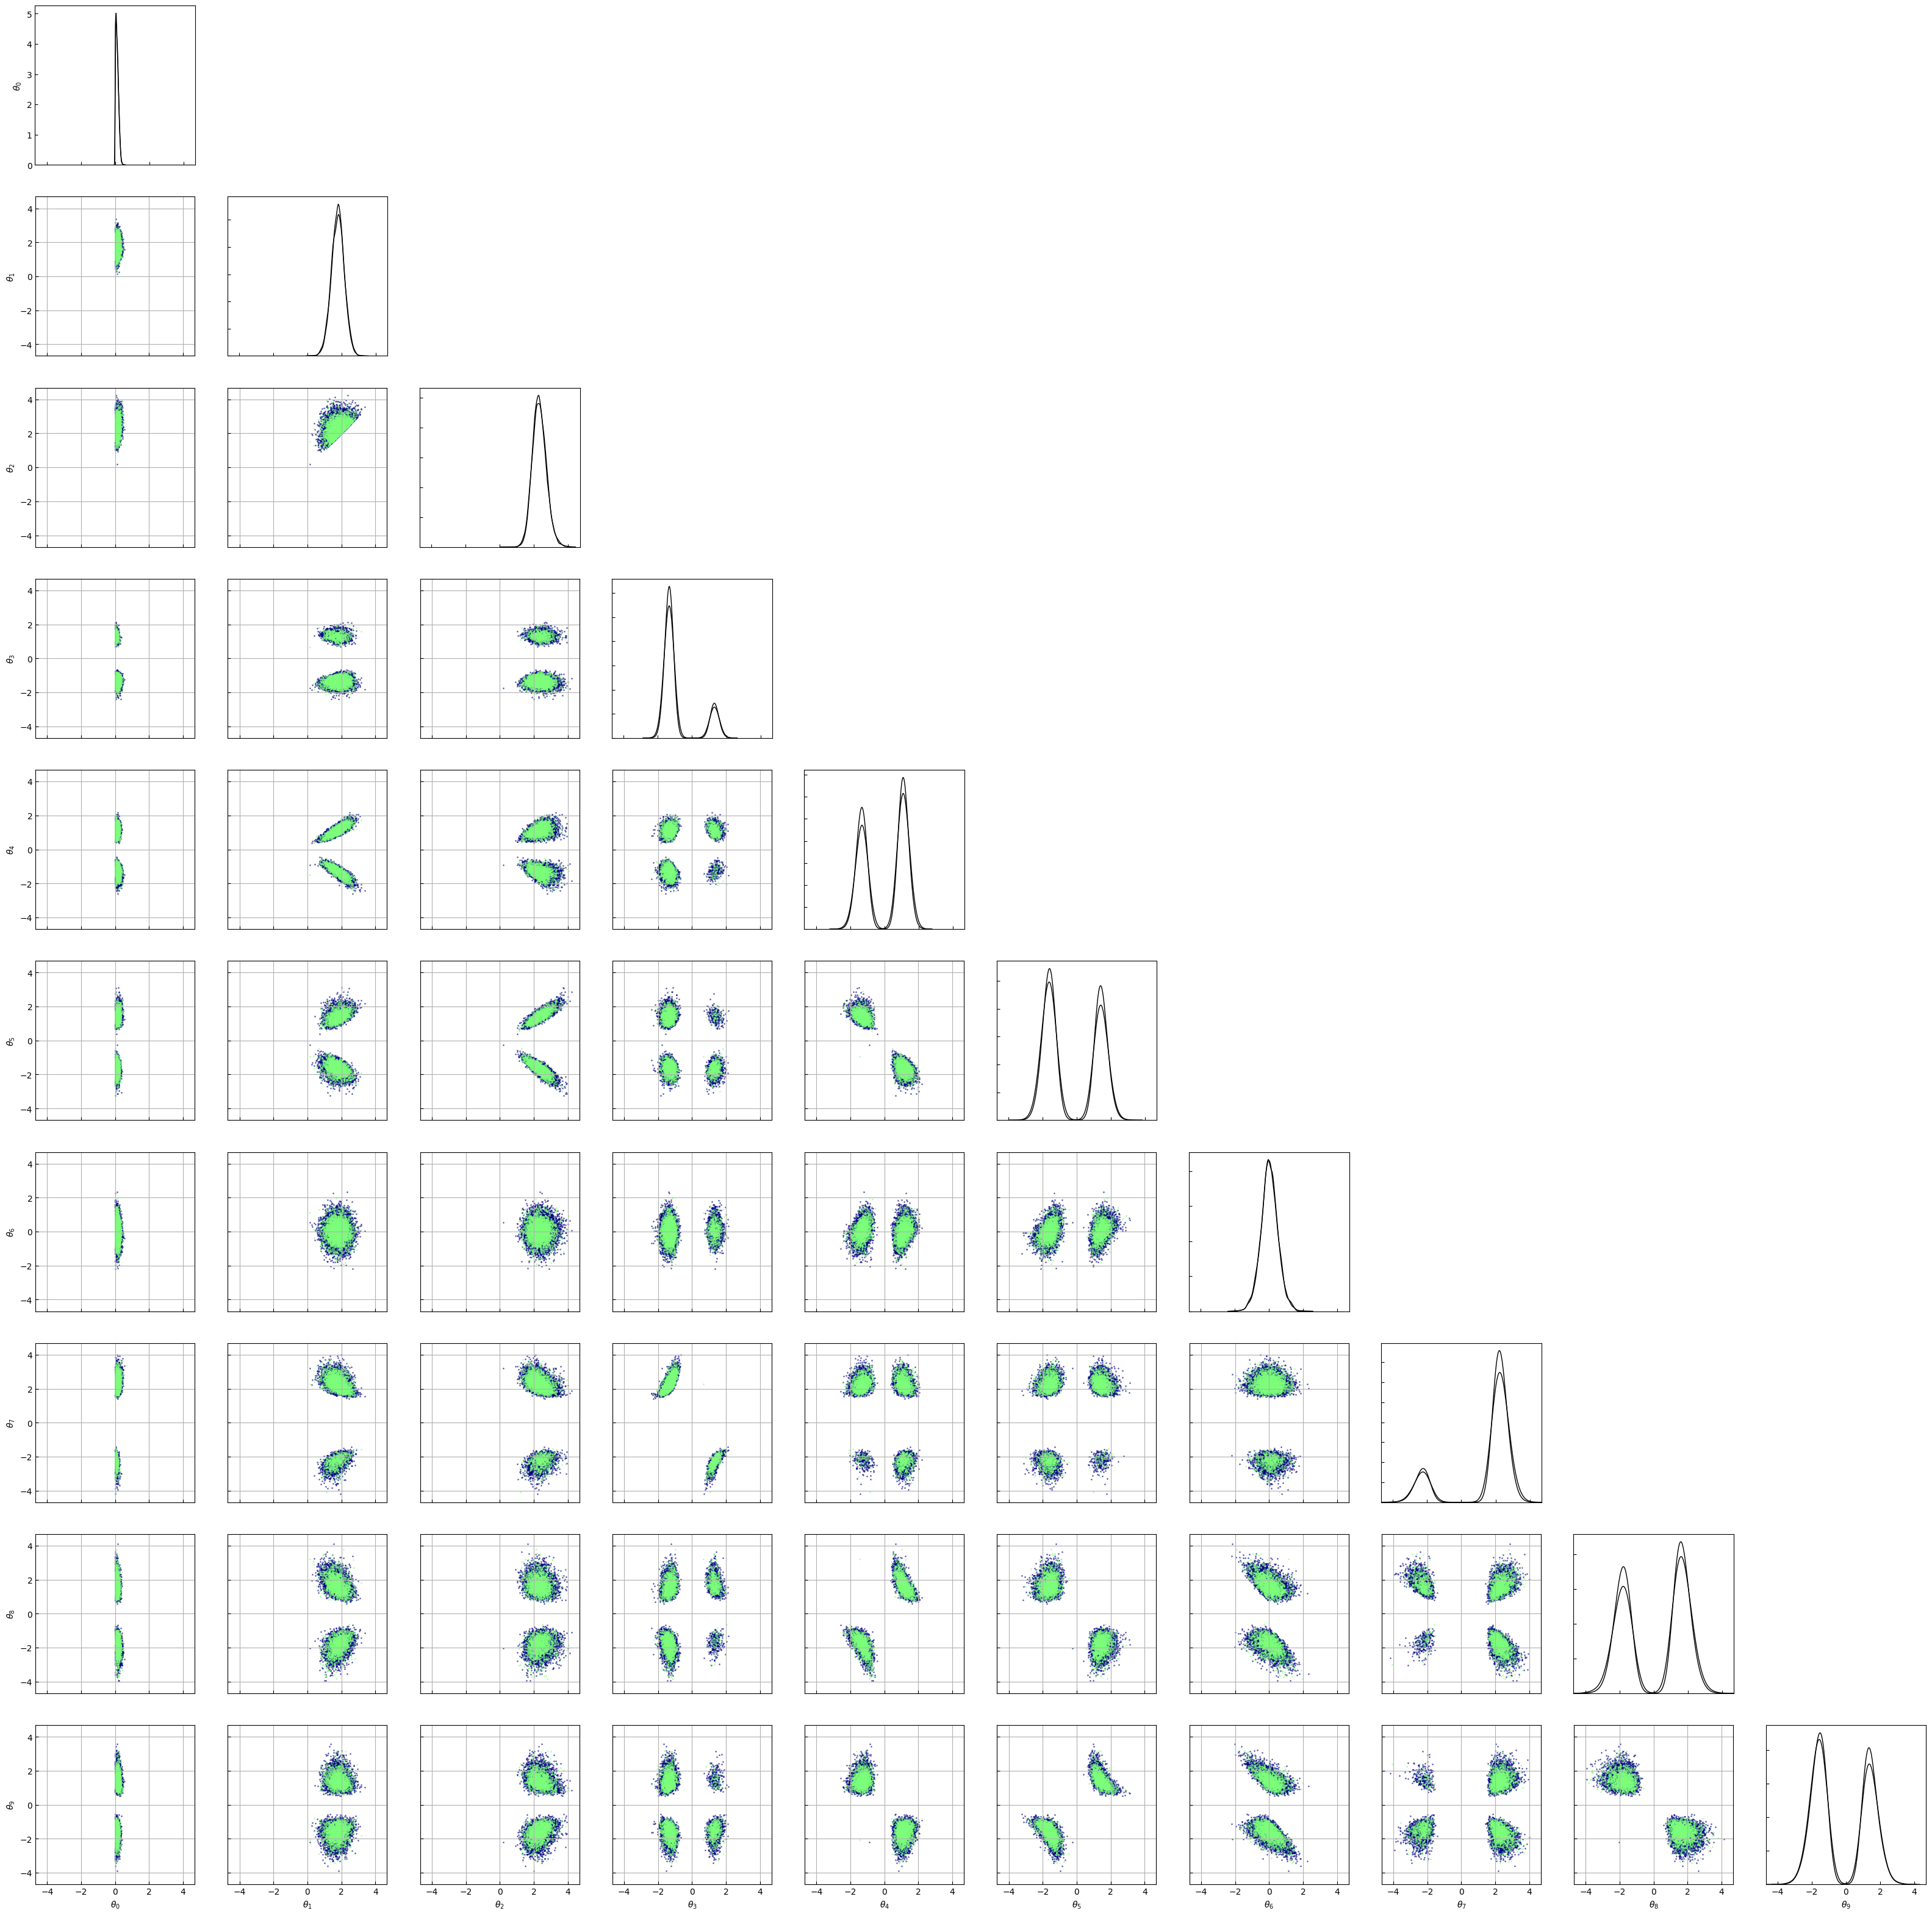

In [3]:
rng_key = jax.random.PRNGKey(0)
rng_key, data_key, split_key = jax.random.split(rng_key, 3)
#dataset = datasets.IRMAE(data_key, n=2**14, latent_dim=latent_dim_gt, output_dim=output_dim, normalization="standardization")
#dataset_train, dataset_validate = dataset.split(split_key, 0.8)
#X_train = dataset_train[:]
#X_validate = dataset_validate[:]

X = jax.random.permutation(rng_key, np.load("mlp_3_1_sinusoidal_0_6.npy"))[:2**14]
neural_network = MLP([3, 1], activation=nn.tanh)
sh = MLPSymmetryHelper(
    parameters_template=neural_network.init(rng_key, jnp.ones((1, 1))),
    activation_function="tanh"
)
X_mirrored = X
X_mirrored = sh.remove_tanh_symmetries(X_mirrored, bias=True)
X_mirrored = sh.remove_permutation_symmetries(X_mirrored, bias=True)
X = X_mirrored

X_train = X[:int(0.8 * len(X))]
X_validate = X[int(0.8 * len(X)):]

print(X_train.shape, X_validate.shape)

# visualization
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=1.0)
    )
)

figure.plot(data_list=[X_train, X_validate])

In [4]:
print(X_train.shape)

(13107, 10)


In [5]:
encoder = Sequential([
    nn.Dense(output_dim),
    nn.tanh,
    nn.Dense(embedding_dim)
])
rank_regularizer = Sequential([
    nn.Dense(embedding_dim),
    nn.Dense(embedding_dim)
])
decoder = Sequential([
    nn.Dense(output_dim),
    nn.tanh,
    nn.Dense(output_dim)
])

rng_key, encoder_key, rank_regularizer_key, decoder_key = jax.random.split(rng_key, 4)
encoder_parameters = encoder.init(encoder_key, jnp.ones((1, output_dim)))
rank_regularizer_parameters = rank_regularizer.init(rank_regularizer_key, jnp.ones((1, embedding_dim)))
decoder_parameters = decoder.init(decoder_key, jnp.ones((1, embedding_dim)))

rng_key, rng_key_ = jax.random.split(rng_key)
parameters = {
    "encoder": encoder_parameters,
    "rank_regularizer": rank_regularizer_parameters,
    "decoder": decoder_parameters,
    "log_std": 0.0
}

In [6]:
def mse_loss(params, x, y):
    encoded = encoder.apply(params["encoder"], x)
    encoded = rank_regularizer.apply(params["rank_regularizer"], encoded)
    x_hat = decoder.apply(params["decoder"], encoded)
    loss = jnp.power(y - x_hat, 2).mean()
    return loss

In [7]:
# optimization
optimizer = optax.adam(learning_rate=0.001)
optimizer_state = optimizer.init(parameters)

In [8]:
parameters, optimizer_state = point_estimate(
    loss_function=jax.jit(mse_loss),
    parameters=parameters,
    inputs=X_train,
    outputs=X_train,
    epochs=10001,
    optimizer=optimizer,
    optimizer_state=optimizer_state,
    report_at=100
)

epoch 0 loss: 2.4663944244384766
epoch 100 loss: 0.6081609129905701
epoch 200 loss: 0.3212539851665497
epoch 300 loss: 0.21269740164279938
epoch 400 loss: 0.15963375568389893
epoch 500 loss: 0.12916472554206848
epoch 600 loss: 0.11074312776327133
epoch 700 loss: 0.10269752889871597
epoch 800 loss: 0.09773734956979752
epoch 900 loss: 0.09380460530519485
epoch 1000 loss: 0.09023114293813705
epoch 1100 loss: 0.08662188053131104
epoch 1200 loss: 0.08146525174379349
epoch 1300 loss: 0.07715001702308655
epoch 1400 loss: 0.0743592381477356
epoch 1500 loss: 0.0722629576921463
epoch 1600 loss: 0.0704571008682251
epoch 1700 loss: 0.06877931207418442
epoch 1800 loss: 0.06717844307422638
epoch 1900 loss: 0.0655648484826088
epoch 2000 loss: 0.06360849738121033
epoch 2100 loss: 0.0615425668656826
epoch 2200 loss: 0.05917458236217499
epoch 2300 loss: 0.05596182867884636
epoch 2400 loss: 0.051802363246679306
epoch 2500 loss: 0.04807089641690254
epoch 2600 loss: 0.044095855206251144
epoch 2700 loss: 0.

In [9]:
encoded = encoder.apply(parameters["encoder"], X_validate)
encoded = rank_regularizer.apply(parameters["rank_regularizer"], encoded)
X_hat = decoder.apply(parameters["decoder"], encoded)

In [10]:
print(X_validate.shape)
print(X_hat.shape)

(3277, 10)
(3277, 10)


In [11]:
print(encoded)

[[ 2.63674825e-01 -7.18767196e-02 -1.61055207e+00 ...  1.45270228e-02
  -1.12605095e+00  1.16282332e+00]
 [ 1.04701065e-01 -3.89264286e-01  1.60272479e+00 ...  4.56944287e-01
   1.11845732e+00 -1.22280633e+00]
 [ 3.09689730e-01 -6.54358566e-02  1.26999700e+00 ...  5.36487758e-01
   7.12648094e-01 -7.17139542e-01]
 ...
 [ 3.41828167e-01 -4.78090793e-02  1.45835042e+00 ...  6.41932309e-01
   9.42889333e-01 -8.18509936e-01]
 [ 1.47557795e-01 -2.31253579e-01  1.36048436e+00 ...  4.35248435e-01
   1.12714648e+00 -1.04327726e+00]
 [ 4.95307297e-01 -2.83767104e-01 -1.35196054e+00 ... -7.49602914e-04
  -5.90517104e-01  7.22766221e-01]]


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


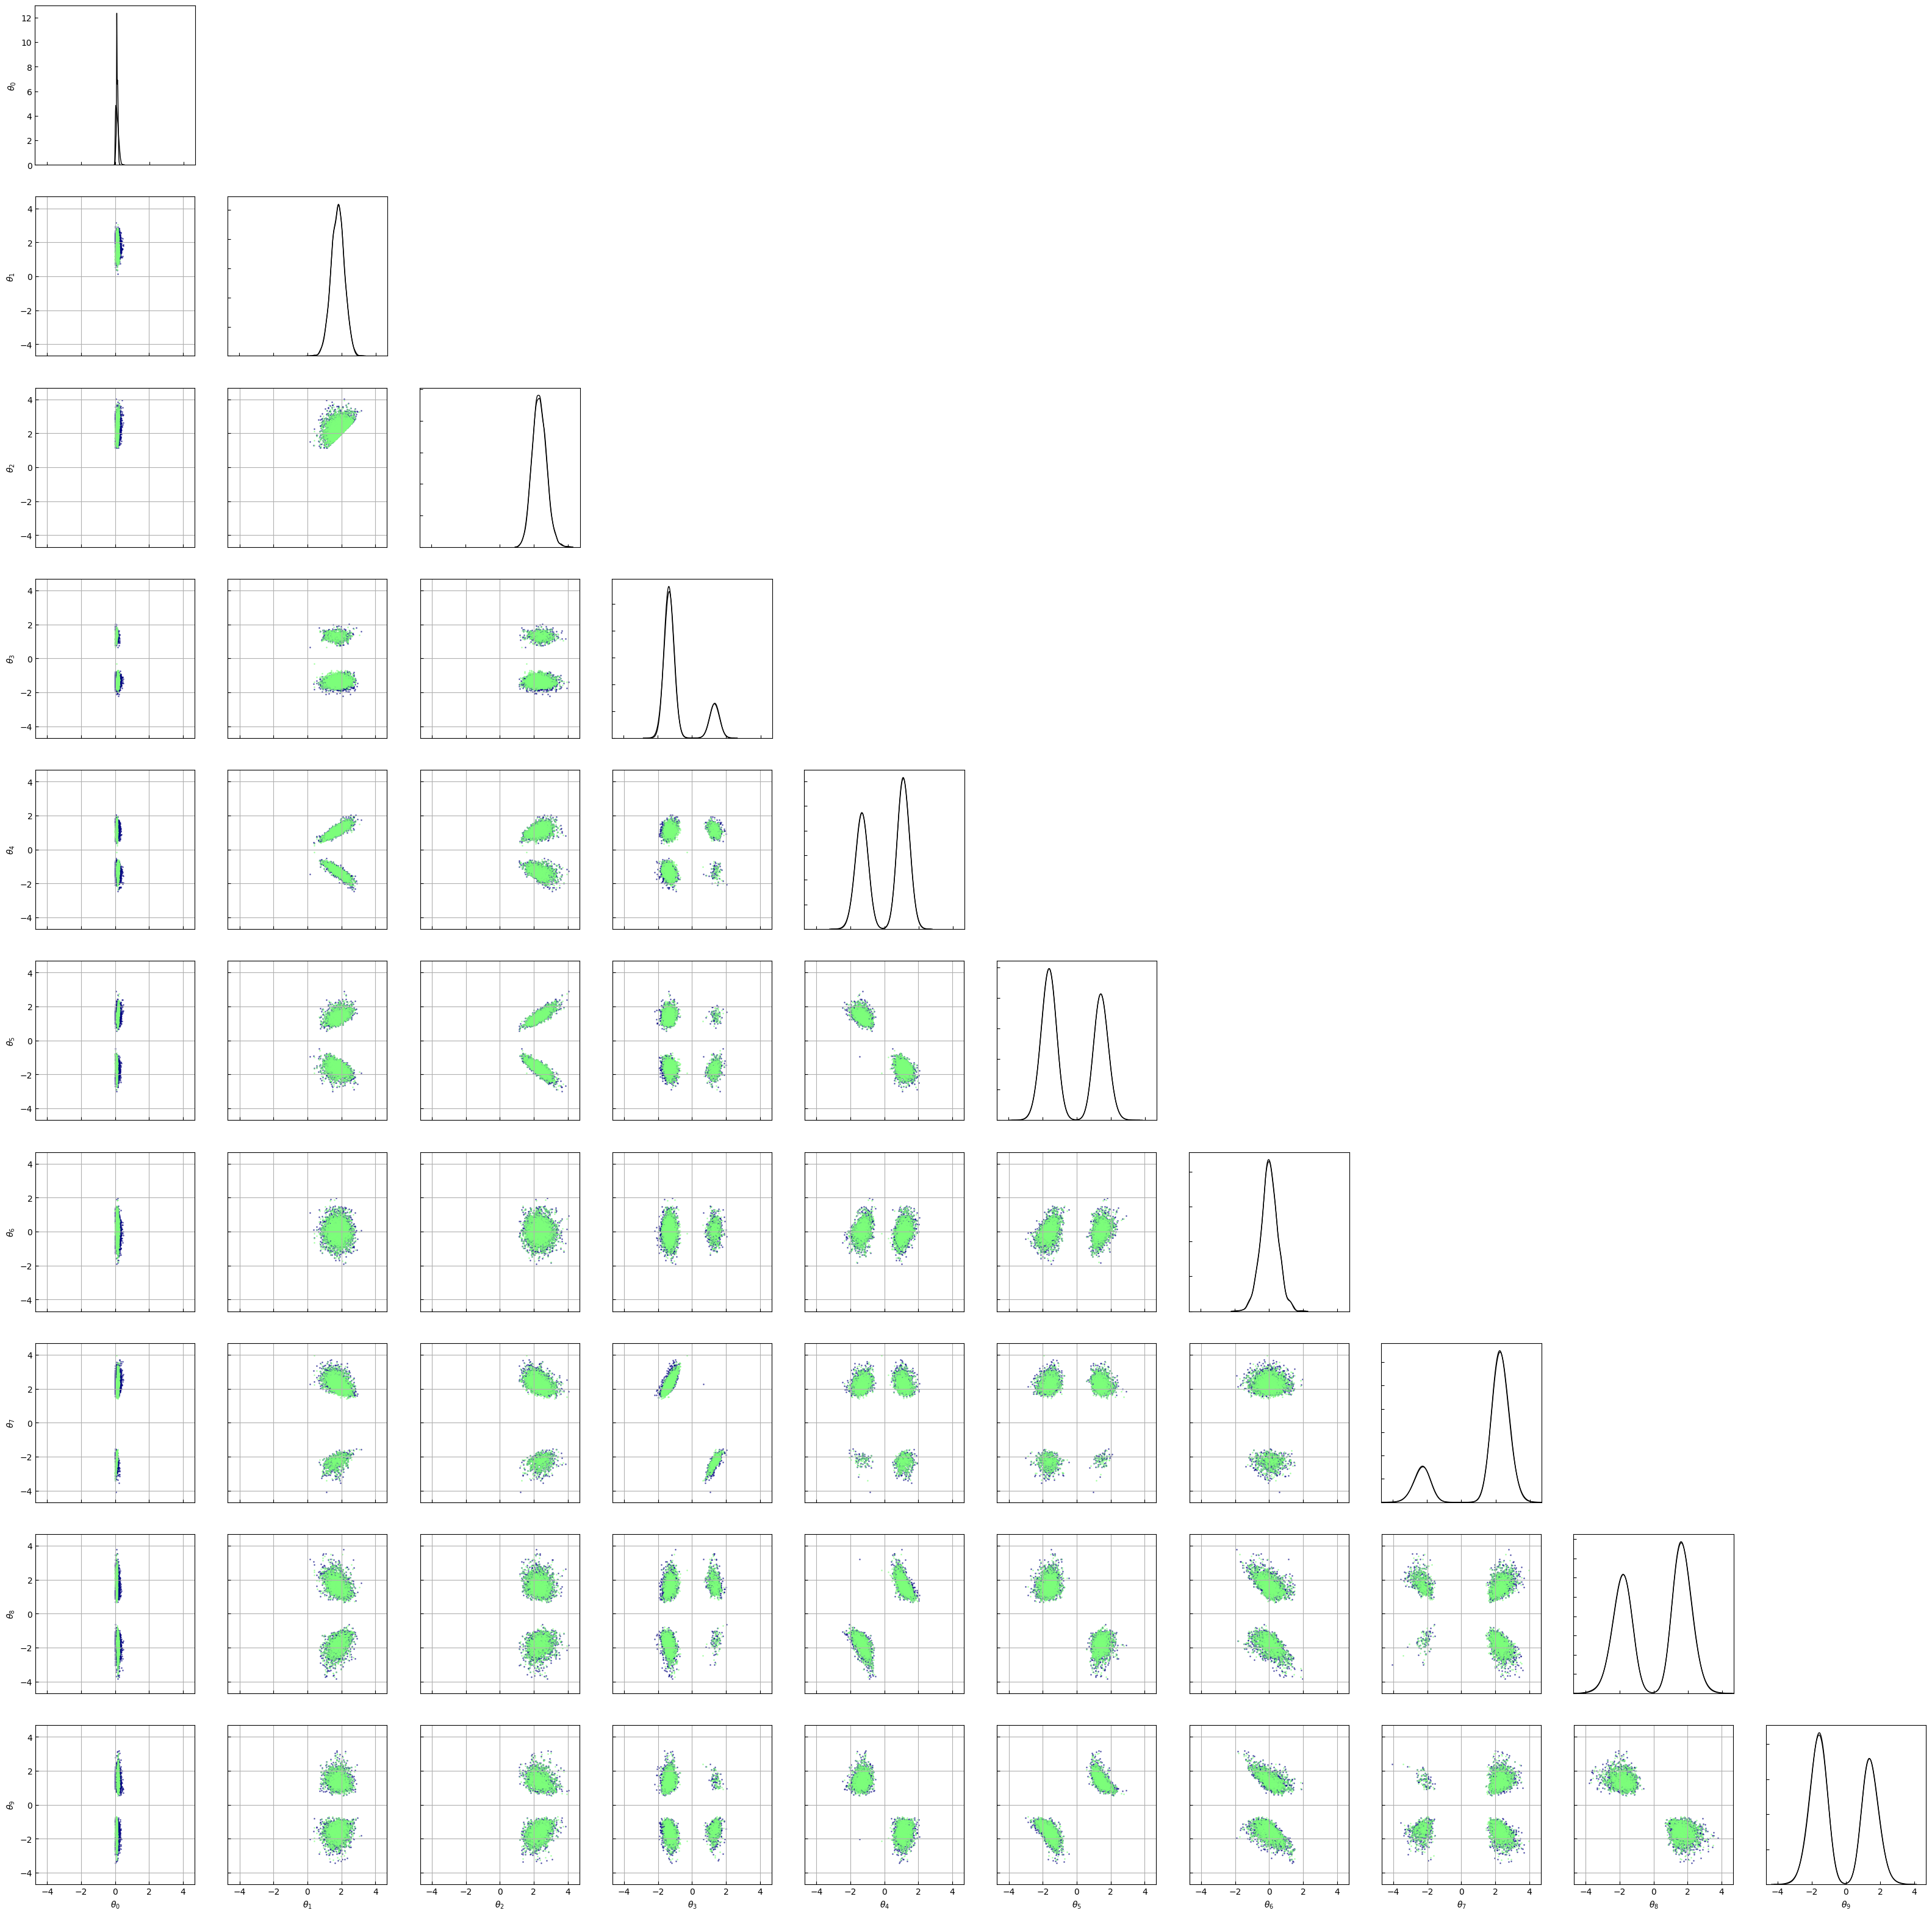

In [12]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=1.0)
    )
)
figure.plot(data_list=[X_validate, X_hat])

# PCA analysis

In [13]:
def eigenvalues_sorted_normalized(samples):
    n = samples.shape[0]
    mean = samples.mean(0)
    covariance = (1.0 / n) * samples.T @ samples - jnp.outer(mean, mean)
    values, vectors = jnp.linalg.eig(covariance)
    
    # convert from complex to float
    values = jnp.array(values, dtype=float)
    values = jnp.flip(jnp.sort(values))
    
    # normalize
    values /= values.max()
    return values

/home/dockeruser/.local/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2548: ComplexWarning: Casting complex values to real discards the imaginary part
  out = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


[1.0000000e+00 3.5019523e-01 3.9252736e-02 2.4666345e-02 2.1158878e-02
 9.9292621e-03 8.0063343e-03 2.9112983e-03 1.4508356e-03 2.3285153e-04]


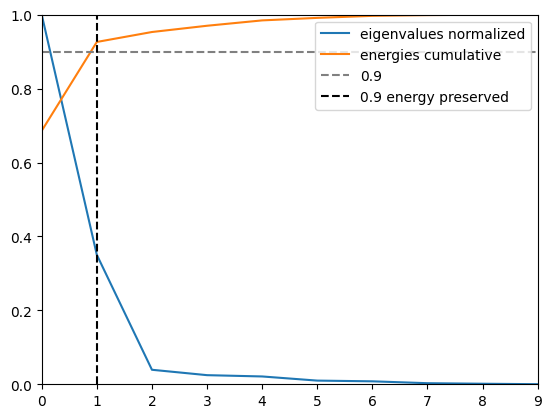

In [14]:
eigenvalues = eigenvalues_sorted_normalized(X_train)
energies = jnp.cumsum(eigenvalues) / jnp.sum(eigenvalues)
print(eigenvalues)
d = eigenvalues.shape[-1]
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_xlim([0.0, d-1])
ax.set_ylim([0.0, 1.0])
ax.plot(jnp.arange(d), eigenvalues, label="eigenvalues normalized")
ax.plot(jnp.arange(d), energies, label="energies cumulative")
ax.hlines(y=0.9, xmin=0.0, xmax=d, linestyles="dashed", color="gray", label="0.9")
ax.vlines(x=jnp.argwhere(energies > 0.9)[0], ymin=0.0, ymax=1.0, linestyles="dashed", color="black", label="0.9 energy preserved")
ax.legend()
figure

In [15]:
# full posterior, not rank minimized: 4 principal components
# full posterior, rank minimized 2l: 3 principal components
# reduced posterior, not rank minimized: 1 principal components
# reduced posterior, rank minimized 2l: 1 principal components
# reduced posterior, kernel - bias, not rank minimized: 0 pc
# reduced posterior, kernel - bias, rank minimized 2l: 0 pc

In [16]:
# no repetition with a simpler AE architecture

# full posterior, not rank minimized: 6
# full posterior, rank minimized 2l: 
# reduced posterior, not rank minimized: 1
# reduced posterior, rank minimized 2l: 1
# reduced posterior, kernel - bias, not rank minimized: 2 pc
# reduced posterior, kernel - bias, rank minimized 2l: 2